In [143]:
import polars as pl
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import mutual_info_classif, SelectKBest, chi2
import pandas as pd
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

In [149]:
df = pd.read_csv("test_data cs 1.csv")
pd.set_option('future.no_silent_downcasting', True)
df = df.sample(n=100, replace=False, random_state=42)

df = df.drop(columns=["screen_name", "text"])

df["verified"] = df["verified"].replace({"f": 0, "t": 1})

df["created_at"] = pd.to_datetime(df["created_at"], format="%a %b %d %H:%M:%S %Y")
df["hour"] = df["created_at"].dt.hour
df["weekday"] = df["created_at"].dt.weekday
df["month"] = df["created_at"].dt.month
df["year"] = df["created_at"].dt.year
df = df.drop(columns=["created_at"]) 

categorical_cols = ["user_lang", "lang", "time_zone", "location", "source"]
for col in categorical_cols:
    freq_map = df[col].value_counts(normalize=True).to_dict()
    df[col] = df[col].replace(freq_map)

eyewitness_order = {"don't know": -1, "non-eyewitness": 0, "indirect-eyewitness": 1, "direct-eyewitness": 2}
df["label"] = df["label"].replace(eyewitness_order)

for col in df.select_dtypes(include=['object']).columns:
    df[col] = pd.to_numeric(df[col], errors='coerce') 

num_cols = ["followers_count", "statuses_count", "friends_count", "favourites_count",
            "listed_count", "cred_score", "eye_truth", "compare_text"]
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
print(df.head)

<bound method NDFrame.head of        user_lang  lang  time_zone  location  verified  friends_count  \
81630       0.30  0.24       0.48      0.54         0      -0.089747   
7201        0.24  0.24       0.48      0.46         0       0.043321   
68170       0.24  0.12       0.52      0.54         0       0.124640   
85236       0.18  0.15       0.48      0.46         0       0.612556   
82466       0.18  0.15       0.52      0.54         0       0.346420   
...          ...   ...        ...       ...       ...            ...   
29321       0.24  0.19       0.48      0.54         0      -0.030606   
18664       0.30  0.30       0.52      0.46         0       0.412954   
7875        0.18  0.30       0.48      0.46         0       0.509059   
40010       0.13  0.24       0.52      0.54         0      -0.082354   
94809       0.13  0.12       0.48      0.54         0       0.095070   

       compare_text  source  favourites_count  listed_count  statuses_count  \
81630     -1.714341    0.0

Train/test split


In [150]:

X = df.drop("verified", axis=1)
y = df["verified"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=42)


GBC using all features of the dataset

In [151]:
gbc = GradientBoostingClassifier(random_state=42)

gbc.fit(X_train, y_train)
preds = gbc.predict(X_test)

f1_score_all = round(f1_score(y_test, preds, average='weighted'), 3)
print(f"F1 Score: {f1_score_all}")

F1 Score: 0.95


Variance Treshold Method

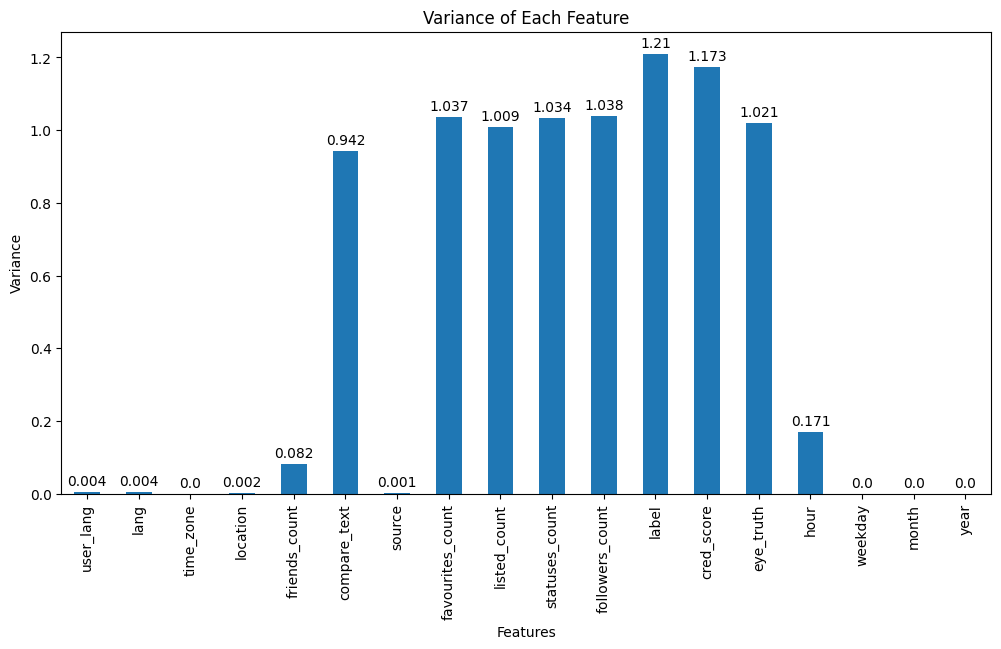

In [153]:
X_train_V = X_train.copy()
variance = X_train_V.var()
plt.figure(figsize=(12, 6))
ax = variance.plot(kind='bar')
for i, v in enumerate(variance):
    ax.text(i, v + 0.01, str(round(v, 3)), ha='center', va='bottom', fontsize=10)
plt.title('Variance of Each Feature')
plt.xlabel('Features')
plt.ylabel('Variance')
plt.xticks(rotation=90)
plt.show()